In [1]:
using NBInclude
@nbinclude("Hofstadter Single Particle in Julia.ipynb")
@nbinclude(joinpath("..","First Band Approximation Functions.ipynb"));

# Initial Parameters

In [2]:
Nx = 8; Ny = 10; N=Nx*Ny; p = 1; q = Ny; cut_off = Nx;
PN = [0,1,2,3];
U = 2;
print("Magnetic flux per unit-cell:",p/q,"\n Number of flux quanta:",Nx)

Magnetic flux per unit-cell:0.1
 Number of flux quanta:8

# Single-Particle

In [3]:
@doc get_sp_op

Compute the single-particle operator from single-particle matrix.

#### Arguments

  * `sp_basis::NLevelBasis`: Single-Particle basis.
  * `N::Integer`: The total site number.
  * `sp_matrix::Matrix`: Hopping phases matrix from any model.


In [4]:
sp_basis = NLevelBasis(N)
periodicity = 0
sp_matrix = Hofstadter_SP(Nx, Ny, p/q, periodicity);

In [5]:
H1 = get_sp_op(sp_basis, N, sp_matrix);

In [6]:
using LinearAlgebra
eigenenergies(dense(H1)) == eigvals(sp_matrix) # true
#show(stdout, "text/plain", eigvals(sp_matrix))

true

In [7]:
@doc get_sub_states

Compute the first eigen-states in a given number.

#### Arguments

  * `sp_op::get_sp_op`: Single-particle operator.
  * `cut_off::Int`: Limit value of eigen-state index.


In [8]:
sub_states = get_sub_states(H1, cut_off);

In [9]:
@doc get_projector_op

Compute sub-space basis, projection and comlex conjugate of projection operator.

#### Arguments

  * `states::get_sub_states`: Eigen-states of the sub-space.
  * `basis::NLevelBasis`: Single-particle basis.


In [10]:
basis_sub, P, Pt = get_projector_op(sub_states, sp_basis);

In [11]:
@doc get_subspace_op

Compute the corresponding operator in the sub-space.

#### Arguments

  * `sp_op::Operator`: Single-particle operator from single-particle matrix.
  * `P::get_projector_op[2]`: Projection operator.
  * `Pt::get_projector_op[3]`: Complex conjugate of projection operator.


In [12]:
H1_sub = get_subspace_op(H1, P, Pt);

In [13]:
@doc get_num_sub_list

Compute the single-particle number operator for each lattice sites.

#### Arguments

  * `N::Integer`: The total site number.
  * `sp_basis::NLevelBasis`: Single-Particle basis.
  * `P::get_projector_op[2]`: Projection operator.
  * `Pt::get_projector_op[3]`: Complex conjugate of projection operator.


In [14]:
num_sub_list = get_num_sub_list(N, sp_basis, P, Pt);

# Many-Body

In [15]:
@doc get_mb_op

Compute the many-body operator for boson particles from single-particle operator.

#### Arguments

  * `basis_mb`: Many-body basis.
  * `basis_sub::get_projector_op[1]`: Sub-space basis.
  * `sp_op::Operator`: Single-particle operator from single-particle matrix.


In [16]:
states_mb = bosonstates(basis_sub, PN) 
basis_mb = ManyBodyBasis(basis_sub, states_mb);

In [17]:
H1_MB = get_mb_op(basis_mb, basis_sub, H1_sub);

In [18]:
@nbinclude("Hofstadter MB in Julia.ipynb"; regex=r"#.*executeme")

Hofstadter_Finite_U (generic function with 1 method)

In [19]:
@doc Hubbard_Interaction

Compute the on-site Bose-Hubbard Interaction term.

#### Arguments:

  * `basis_cut_sp`: The cutt-off sites of bosonic many-body basis.
  * `basis_cut_mb`: The cutt-off sites of single-particle basis.
  * `P::Operator`: Projection operator.
  * `Pt::Operator`: Complex conjugate of projection operator.
  * `cut_off::Int`: Limit value of eigen-state index.


In [20]:
basis_cut_mb, basis_cut_sp = get_Bosonic_MB_Basis(cut_off,PN)
H_Int = Hubbard_Interaction(basis_cut_sp, basis_cut_mb, P, Pt, cut_off);

# Constructing Total Hamiltonians 

In [21]:
H1cut = SparseOperator(basis_cut_mb)
H1cut.data = H1_MB.data

number_mb_list_operators = get_num_mb_op(N, basis_cut_sp, num_sub_list, basis_cut_mb, basis_sub)

function get_total_H(V, imp_site, number_mb_list_operators, H1cut, H_Int)
    V_imp = V * number_mb_list_operators[imp_site]
    H_totall = H1cut + H_Int + V_imp
    return H_totall
end

imp_site = 44
H_total_imp = get_total_H(4, imp_site, number_mb_list_operators, H1cut, H_Int)
H_total = get_total_H(0, 45, number_mb_list_operators, H1cut, H_Int);

# Exact-Diagonalization

In [22]:
using DataFrames

E, V = eigenstates(dense((H_total_imp+dagger(H_total_imp))/2))
E0, V0 = eigenstates(dense((H_total+dagger(H_total))/2))

function get_energies(pn, E, V, basis)
    PN_Energies = Array{Float64}(undef, length(E), 2)
    for i in 1:length(E)
        PN_Energies[i] = round(expect(number(basis), V[i])) #expected values (first column)
        PN_Energies[i,2] = E[i] #eigen-values (second column)
    end
    
    # filter
    df = DataFrame(PN_Energies, :auto)
    df = filter(row -> (row.x1 == pn),  df)
    
    return df
end

get_energies (generic function with 1 method)

In [23]:
PN

4-element Vector{Int64}:
 0
 1
 2
 3

In [24]:
pn = 3.0
df = get_energies(pn, E, V, basis_cut_mb)
df_0 = get_energies(pn, E0, V0, basis_cut_mb)
# V \neq 0
filtered_energies = Matrix(df)[:,2]
# V=0
filtered_energies_0 = Matrix(df_0)[:,2]
#show(stdout,"text/plain", filtered_energies) #show all outputs

120-element Vector{Float64}:
 -10.259932886485375
 -10.259932886485373
 -10.259901993554315
 -10.259901993554308
 -10.25990023222438
 -10.259900232224377
 -10.259900232224377
 -10.259900232224373
 -10.259850864410984
 -10.259850864410982
 -10.25985086441098
 -10.259850864410977
 -10.259849006190192
   ⋮
  -9.961172883168818
  -9.96117288316881
  -9.961002871235502
  -9.9610028712355
  -9.958174841380709
  -9.958174841380703
  -9.95783656383475
  -9.957836563834746
  -9.957836563834745
  -9.957836563834743
  -9.957496405192192
  -9.957496405192186

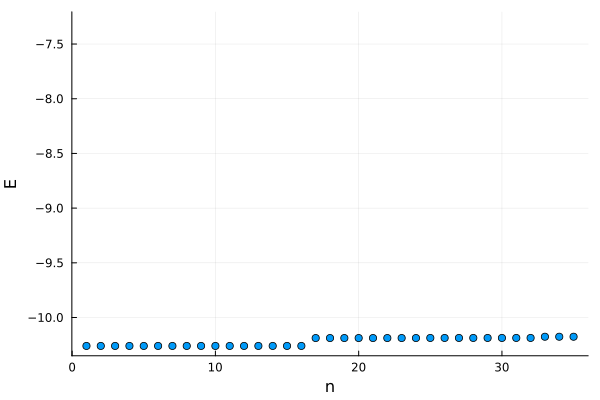

In [25]:
using Plots
Plots.plot(1:35,E0,seriestype=:scatter,xlabel="n",ylabel="E",legend=false)
#ylims!((-7.20544,-7.20536)) # Onur hocanın makalesinde ki FIG1 için sınırlar
Plots.ylims!(( -10.35,-7.20536))

Allta ki fonksiyonun çalışması için, dizide ki filtre edilmiş parçacık sayısı her zaman en büyük değer de olmalıdır.
Örneğin, `PN=[0,1,2,3,4]` iken filtre edilen parçacık sayısı `pn=4` olmalıdır!

In [26]:
function Restricted_Hubbard_States(states)
    number_of_states = length(filtered_energies)
    return states[1:number_of_states];
end

Restricted_Hubbard_States (generic function with 1 method)

In [27]:
r_hubbard_states = Restricted_Hubbard_States(V);
r_hubbard_states_0 = Restricted_Hubbard_States(V0);

# Densities

<font size="4">
$<n_i>, \quad \text{i: site index}$
</font>

In [28]:
# METHOD 1

NM_MB_Array_Storage = zeros(Complex{Float64},length(basis_cut_mb),length(basis_cut_mb),N);
NM_MB_Matrix = zeros(Complex{Float64},length(basis_cut_mb),length(basis_cut_mb));
for m in 1:N
    for i in 1:length(basis_cut_mb)
        for j in 1:length(basis_cut_mb)
            #NM_MB_Matrix[i,j] = num_mb_list[m].data[i,j]
            NM_MB_Matrix[i,j] = number_mb_list_operators[m].data[i,j]
            # NOT: num_mb_list ile number_mb_list_operators bazları farklı ama içerikleri aynı!
        end
    end
    NM_MB_Array_Storage[:,:,m] = NM_MB_Matrix
end

BL = BR = basis_cut_mb
index_number_op = 4
T = NM_MB_Array_Storage[:,:,index_number_op]
Op = Operator(BL,BR,T)
index_eigen_states = 1
expect(Op, r_hubbard_states[index_eigen_states])
expect(Op, r_hubbard_states_0[index_eigen_states])

#or
# expect(number_mb_list_operators[index_number_op],r_hubbard_states[index_eigen_states])

0.056147989239729724 - 4.389882615309532e-19im

<font size="4">
$\sum_{i} <\psi_j|n_j|\psi_j>, \quad \text{for a given j index}$
</font>

In [29]:
index_eig_states = 1

function get_density_profiles(NM_MB_Array_Storage, r_hubbard_states, index_eig_states)
    Sum = 0
    expect_list=[]
    for i in 1:N
        T = NM_MB_Array_Storage[:,:,i]
        Op = Operator(BL,BR,T)   
        Sum += expect(Op, r_hubbard_states[index_eig_states])
        push!(expect_list, expect(Op, r_hubbard_states[index_eig_states]))
    end
    return real(expect_list)
end

get_density_profiles(NM_MB_Array_Storage,r_hubbard_states, index_eig_states)

80-element Vector{Float64}:
 0.04897975754606998
 0.05283610960700737
 0.059204140591718545
 0.06331547289550829
 0.05920414059129104
 0.05283610960624559
 0.0489797575452305
 0.04864334686942337
 0.035986391170550365
 0.03798489998228845
 0.041807089776743286
 0.04443260436323079
 0.04180708978026039
 ⋮
 0.02893256010480624
 0.0318041628444072
 0.03423895356934607
 0.03474700910158761
 0.03598639116486954
 0.0379848999810002
 0.04180708978035307
 0.04443260436345958
 0.041807089776192234
 0.037984899980668285
 0.03598639116818403
 0.03595696046175254

In [30]:
# ORTALAMA:

Degeneracy = 7
avg_density = zeros((Nx,Ny)) 
for index_eig_states in 1:Degeneracy
    avg_density += reshape(get_density_profiles(NM_MB_Array_Storage, r_hubbard_states, index_eig_states),Nx,Ny)
end    
avg_density = avg_density / Degeneracy;

Degeneracy_0 = 16
avg_density_0 = zeros((Nx,Ny))
for index_eig_states in 1:Degeneracy_0
    avg_density_0 += reshape(get_density_profiles(NM_MB_Array_Storage, r_hubbard_states_0, index_eig_states),Nx,Ny)
end    
avg_density_0 = avg_density_0 / Degeneracy_0;

# Degeneracy_0 => Örgüde 2 quasi boştayken

# Density Heat-Maps

In [31]:
site_idx = range(1,Nx*Ny) 
lattice = reverse(OffsetArray(reshape(site_idx, (Ny,Nx)), 1:Ny, 1:Nx), dims=1)
coordinates = []
for x in 0:Nx-1
    for y in 0:Ny-1
        coordinates = [coordinates; x; y]
    end
end
coordinates = reshape(coordinates, (2, Nx*Ny)) |> transpose;

In [46]:
lattice

10×8 OffsetArray(::Matrix{Int64}, 1:10, 1:8) with eltype Int64 with indices 1:10×1:8:
 10  20  30  40  50  60  70  80
  9  19  29  39  49  59  69  79
  8  18  28  38  48  58  68  78
  7  17  27  37  47  57  67  77
  6  16  26  36  46  56  66  76
  5  15  25  35  45  55  65  75
  4  14  24  34  44  54  64  74
  3  13  23  33  43  53  63  73
  2  12  22  32  42  52  62  72
  1  11  21  31  41  51  61  71

In [32]:
function find_co(p)
    x_co = coordinates[:,1]
    y_co = coordinates[:,2]
    x = hcat(x_co, y_co)[p, 1]
    y = hcat(x_co, y_co)[p, 2]
    return x, y
end
function distance(p1,p2)
    return sqrt( (find_co(p2)[1] - find_co(p1)[1])^2 + (find_co(p2)[2] - find_co(p1)[2])^2 )
end
distance(47,18)

3.1622776601683795

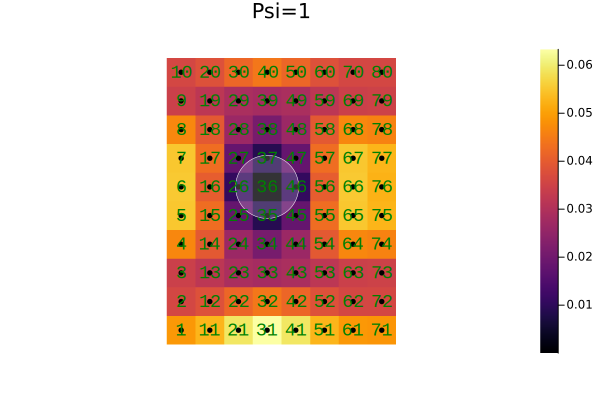

In [33]:
Plots.heatmap(reshape(get_density_profiles(NM_MB_Array_Storage, r_hubbard_states, index_eig_states), Nx, Ny)|>transpose)

# # koordinatları 0 yerine 1'den başlatırsak heatmap ile uyumlu olur (.+1 operasyonu)
x_coordinates = coordinates[:,1] .+1
y_coordinates = coordinates[:,2] .+1
Plots.scatter!(x_coordinates, y_coordinates, label=false, aspect_ratio=1, showaxis = false, grid=false, markersize=3, c=:black, title="Psi=1")

for i in 1:N
    p = annotate!(x_coordinates[i],y_coordinates[i], text("$i", :Courier, 10,:green))
end

function circle_shape(h,k,r)
    beta = reverse(LinRange(0, 2*pi, 500))
    h .+ r*sin.(beta), k .+ r*cos.(beta)
end

# Bu örnekte imp_site=44 aslında 36.site'dır. Çünkü burada density en düşüktür.
center_x = x_coordinates[36]; center_y = y_coordinates[36]; radius = 1+0.1
plot!(circle_shape(center_x,center_y,radius), seriestype=[:shape], lw=0.5, c=:white, linecolor= :white, legend=false, fillalpha=0.2)

p

In [45]:
function get_inner_sites(radius)
    inner_sites = []
    for i in 1:N
        if (x_coordinates[i] - center_x)^2 + (y_coordinates[i] - center_y)^2 < radius^2
            push!(inner_sites, i)
        end
    end
    return inner_sites
end

get_inner_sites (generic function with 1 method)

# Interpolation

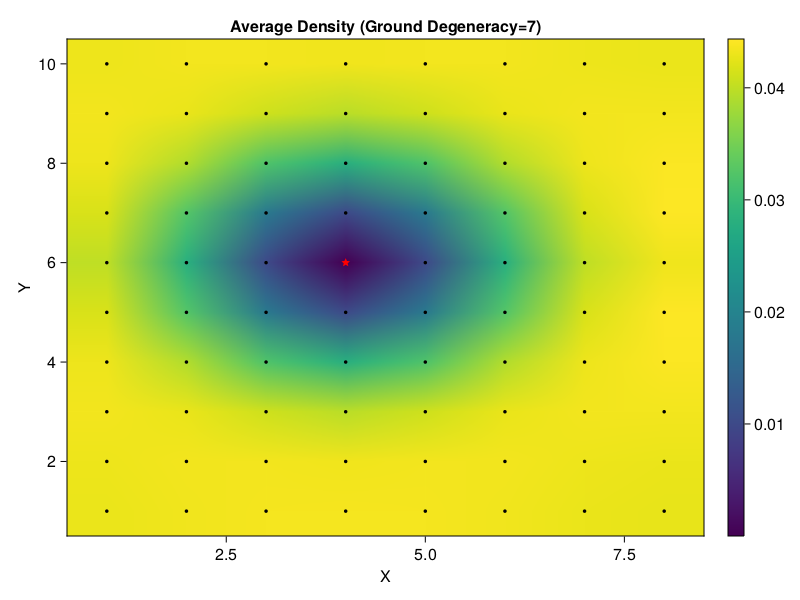

In [35]:
using CairoMakie

fig = Figure()
ax = Axis(fig[1,1], title="Average Density (Ground Degeneracy=$(Degeneracy))", xlabel="X", ylabel="Y");

hm = CairoMakie.heatmap!(avg_density, interpolate=true)
Colorbar(fig[1, 2], hm)

x_coordinates = square_lattice(Nx,Ny)[2][:,1] .+ 1
y_coordinates = square_lattice(Nx,Ny)[2][:,2] .+ 1
CairoMakie.scatter!(x_coordinates, y_coordinates, color=:black, markersize=5)

center_x = x_coordinates[imp_site]; center_y = y_coordinates[imp_site]
CairoMakie.scatter!([center_x], [center_y], color=:red, markersize=10, marker= :star5)

fig

# $ Q_{\rho}$

<font size="3">
$Q_{\rho} = \sum_i \left(<n_i>_{V=0}-<n_i>_{V \neq 0} \right)$
</font>

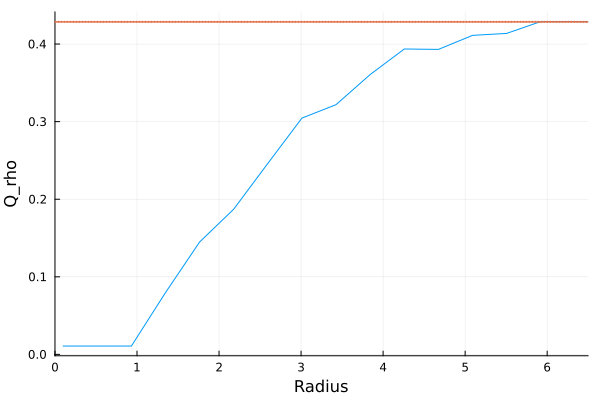

In [44]:
Radius = range(0.1, 8, length=20)
function get_Q_rhos(Radius)
    Q_rho = []
    for radius in Radius
        Sum = 0
        for i in get_inner_sites(radius)
            Sum += collect(Iterators.flatten((3/70 .- avg_density|>transpose)))[i]
            #3/7 => Latiste sadece 1 quasi varken ve boştayken
            #avg_density_0 => Latiste iki boşta quasi varken
        end
        push!(Q_rho, Sum)
    end
    return Q_rho
end
Plots.plot(Radius, get_Q_rhos(Radius), xlabel="Radius",ylabel="Q_rho", legend=false)
g(x)=3/7
Plots.plot!(g, 0, length(Radius), line=(:dot,2),xlim=(0,6.5))

# Animation

In [39]:
# animated_exp_list = zeros(N,1,length(r_hubbard_states))
# function animated_e_l()
#     for i in 1:length(r_hubbard_states)
#         expect_list=[]
#         for j in 1:N
#             T = NM_MB_Array_Storage[:,:,j]
#             Op = Operator(BL,BR,T)
#             push!(expect_list,expect(Op, r_hubbard_states[i]))
#         end
#         animated_exp_list[:,:,i] = real(expect_list)
#     end
#     return animated_exp_list
# end

In [40]:
# k = 1
# initial_condition = reshape(animated_e_l()[:,:,k], Nx, Ny) #psi_1 (psi_k)'e karşılık gelen density matrix
# heatmap(initial_condition)

In [41]:
# initial_condition = reshape(animated_e_l()[:,:,1], Nx, Ny)
# fps = 20
# function heatgif(initial_condition)
#     p = heatmap(initial_condition, xlabel="x", ylabel="y", title=("Nx=$Nx,Ny=$Ny,co=$cut_off,PN=$pn,U=$U, fps=$fps"))
#     anim = @animate for i=1:length(r_hubbard_states)
#         h_map_matrix = reshape(animated_e_l()[:,:,i],Nx,Ny)
#         heatmap!(p[1], h_map_matrix)
#     end
#     return anim
# end

In [42]:
# anim = heatgif(initial_condition)
# gif(anim, "OUTPUT.gif", fps=fps)